## Step 3: Optimization with uncertain conversion rates

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from Environment.E_commerce import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.TS_Learner import *
from Algorithms.UCB_Learner import *

In [2]:
P1 = Product(0,[9,12,13,14.5],[ 1.,  4,  5., 6.5])
P2 = Product(1,[20,22.5,23,24.5],[ 4.,  6.5, 7., 8.5])
P3 = Product(2,[30,31.5,34,34.5],[ 6.,  7.5, 10., 10.5])
P4 = Product(3,[40,42.5,43,46.5],[ 8., 10.5, 11., 14.5])
P5 = Product(4,[50,51.5,53,54.5],[10., 11.5, 13., 14.5])

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = E_commerce()
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])
E.set_products(products)
E.set_lambda(0.5)

In [3]:
#Random algorithm which for each round pulls a random choice 
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
# useful for computing clairvoyant solution and regrets of the bandit algorithms


n_arms = 4
num_users = 1000
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i] 
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms

_______________________________________________
Conversion rates
[[0.85722034 0.58220972 0.48766625 0.35697918]
 [0.77927968 0.52297288 0.47669453 0.34924465]
 [0.77360646 0.626446   0.38031299 0.3446695 ]
 [0.78674579 0.5335949  0.48810496 0.19647073]
 [0.75771446 0.59594896 0.43415963 0.31605077]]
_______________________________________________
Expected rewards per arm
[[ 1.71304187  4.62930823  4.81538417  4.58230722]
 [ 3.10421865  3.36253306  3.29937703  2.91888302]
 [13.88036276 13.98520331 11.23694476 10.69644687]
 [18.85321602 16.64136378 15.86668276  8.39960369]
 [ 7.58390292  6.85647906  5.64178998  4.57569847]]
_______________________________________________
Expected units sold per arm
[[2. 2. 2. 2.]
 [1. 1. 1. 1.]
 [3. 3. 3. 3.]
 [3. 3. 3. 3.]
 [1. 1. 1. 1.]]
_______________________________________________
Best configuration [2. 1. 1. 0. 0.]
Optimal cumulative expected reward per round
49.040632649275935


In [4]:
#Comparison between TS and UCB

n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 10

ts_rewards_per_experiment = []
ucb_rewards_per_experiment = []
gr_rewards_per_experiment = []
cr_rewards_per_experiment = []

ts_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    gr_learner = Greedy(n_arms=n_arms)
    ucb_learner = UCB(n_arms=n_arms)
    ts_learner = TS(n_arms=n_arms)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)

        pulled_arm = gr_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        gr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day)  

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)
    gr_rewards_per_experiment.append(gr_learner.collected_rewards)
    cr_rewards_per_experiment.append(cr_learner.collected_rewards)

    ts_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)


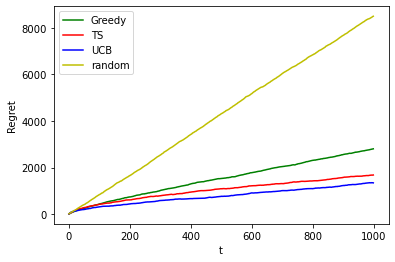

In [5]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g')
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.plot(np.cumsum(np.mean(opt - cr_rewards_per_experiment, axis=0)), 'y')
plt.legend(["Greedy","TS","UCB","random"])
plt.show()

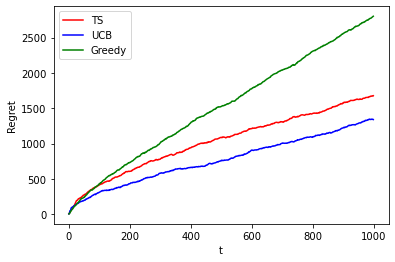

In [6]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g')
plt.legend(["TS","UCB", "Greedy"])
plt.show()

In [7]:
print("_______________________________________________")
print("TS Total collected reward")
print(np.sum(np.mean(ts_rewards_per_experiment,axis=0)))
print("UCB Total collected reward")
print(np.sum(np.mean(ucb_rewards_per_experiment,axis=0)))
print("_______________________________________________")

print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print("TS",np.mean(np.sum(ts_rewards_per_experiment, axis=1)),np.std(np.sum(ts_rewards_per_experiment, axis = 1)))
print("UCB",np.mean(np.sum(ucb_rewards_per_experiment, axis=1)),np.std(np.sum(ucb_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print("TS",np.mean(np.sum(opt - ts_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ts_rewards_per_experiment, axis=1)))
print("UCB",np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ucb_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print("TS",np.mean(np.mean(ts_rewards_per_experiment, axis=0)), np.std(np.mean(ts_rewards_per_experiment, axis=0)))
print("UCB",np.mean(np.mean(ucb_rewards_per_experiment, axis=0)), np.std(np.mean(ucb_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print("TS",np.mean(np.mean(opt-ts_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ts_rewards_per_experiment, axis=0)))
print("UCB",np.mean(np.mean(opt-ucb_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ucb_rewards_per_experiment, axis=0)))

_______________________________________________
TS Total collected reward
47363.075952380954
UCB Total collected reward
47700.1439484127
_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 1000 days and its standard deviation considering 10 experiments
TS 47363.075952380954 229.32527799119325
UCB 47700.1439484127 223.24602569998265
-----------------------------------------------
Total expected regret over 1000 days and its standard deviation considering 10 experiments
TS 1677.5566968949831 229.3252779911942
UCB 1340.4887008632372 223.24602569998228
-----------------------------------------------
Average expected reward per round over 1000 days and its standard deviation between the rounds considering 10 experiments
TS 47.36307595238095 2.599564848204438
UCB 47.700143948412695 2.56541094257631
-----------------------------------------------
Average expected regret per round over 1000 

In [8]:
print("TS Pulls per arm")
for i in range(len(ts_pulls_per_arm_per_experiment)):
    print("_______________________________________________")
    print(ts_pulls_per_arm_per_experiment[i])

TS Pulls per arm
_______________________________________________
[[  1. 412. 466. 121.]
 [ 88. 520. 348.  44.]
 [613. 338.  26.  23.]
 [923.  28.  34.  15.]
 [845. 118.  23.  14.]]
_______________________________________________
[[  1. 256. 510. 233.]
 [ 90. 682. 140.  88.]
 [474. 466.  35.  25.]
 [938.  38.  16.   8.]
 [896.  77.  11.  16.]]
_______________________________________________
[[  1.  52. 702. 245.]
 [ 16. 405. 499.  80.]
 [825.  96.  46.  33.]
 [866.  56.  51.  27.]
 [924.  18.  39.  19.]]
_______________________________________________
[[  1.  80. 730. 189.]
 [  4. 680. 172. 144.]
 [793. 133.  33.  41.]
 [757. 209.  27.   7.]
 [959.  18.  14.   9.]]
_______________________________________________
[[  1. 286. 352. 361.]
 [  7. 841.  91.  61.]
 [133. 772.  70.  25.]
 [919.  46.  24.  11.]
 [920.  47.  19.  14.]]
_______________________________________________
[[  1. 125. 481. 393.]
 [ 17. 203. 676. 104.]
 [773. 180.  15.  32.]
 [852. 118.  25.   5.]
 [897.  32.  60.  11.]]

In [9]:
print("UCB Pulls per arm")
for i in range(len(ucb_pulls_per_arm_per_experiment)):
    print("_______________________________________________")
    print(ucb_pulls_per_arm_per_experiment[i])

UCB Pulls per arm
_______________________________________________
[[  2. 121. 874.   3.]
 [120.   6. 815.  59.]
 [274. 700.  24.   2.]
 [766. 157.  75.   2.]
 [927.  31.  38.   4.]]
_______________________________________________
[[  2. 255.  25. 718.]
 [225.   2. 771.   2.]
 [994.   2.   2.   2.]
 [994.   2.   2.   2.]
 [935.  42.  17.   6.]]
_______________________________________________
[[  2.   3. 989.   6.]
 [  2. 994.   2.   2.]
 [438. 539.   2.  21.]
 [809.  98.  91.   2.]
 [994.   2.   2.   2.]]
_______________________________________________
[[  2.  70. 864.  64.]
 [197. 525. 276.   2.]
 [994.   2.   2.   2.]
 [838. 140.  20.   2.]
 [956.  40.   2.   2.]]
_______________________________________________
[[  2. 160. 421. 417.]
 [ 54. 937.   7.   2.]
 [776. 196.   2.  26.]
 [993.   3.   2.   2.]
 [  2. 994.   2.   2.]]
_______________________________________________
[[  2. 321. 497. 180.]
 [ 20. 688. 225.  67.]
 [494. 465.  25.  16.]
 [846. 116.  36.   2.]
 [994.   2.   2.   2.]

In [10]:
#Comparison between TS and UCB with respect to the number of users per round

n_arms = 4
num_users = 10
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 10

ts_rewards_per_experiment_10 = []
ucb_rewards_per_experiment_10 = []

ts_rewards_per_experiment_100 = []
ucb_rewards_per_experiment_100 = []


ts_rewards_per_experiment_1000 = []
ucb_rewards_per_experiment_1000 = []


for e in range(n_experiments):

    env_10 = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_10 = UCB(n_arms=n_arms)
    ts_learner_10 = TS(n_arms=n_arms)

    env_100 = Environment(n_arms, E, margins_matrix, num_users*10, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_100 = UCB(n_arms=n_arms)
    ts_learner_100 = TS(n_arms=n_arms)

    env_1000 = Environment(n_arms, E, margins_matrix, num_users*100, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_1000 = UCB(n_arms=n_arms)
    ts_learner_1000 = TS(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ucb_learner_10.pull_arm()
        reward = env_10.round(pulled_arm)
        ucb_learner_10.update(pulled_arm, reward)

        pulled_arm = ucb_learner_100.pull_arm()
        reward = env_100.round(pulled_arm)
        ucb_learner_100.update(pulled_arm, reward)

        pulled_arm = ucb_learner_1000.pull_arm()
        reward = env_1000.round(pulled_arm)
        ucb_learner_1000.update(pulled_arm, reward)
        
        pulled_arm = ts_learner_10.pull_arm(env_10.margins_matrix)
        reward = env_10.round(pulled_arm)
        ts_learner_10.update(pulled_arm, reward, env_10.clicks_current_day, env_10.purchases_current_day, env_10.daily_units)

        pulled_arm = ts_learner_100.pull_arm(env_100.margins_matrix)
        reward = env_100.round(pulled_arm)
        ts_learner_100.update(pulled_arm, reward, env_100.clicks_current_day, env_100.purchases_current_day,  env_100.daily_units)

        pulled_arm = ts_learner_1000.pull_arm(env_1000.margins_matrix)
        reward = env_1000.round(pulled_arm)
        ts_learner_1000.update(pulled_arm, reward, env_1000.clicks_current_day, env_1000.purchases_current_day,  env_1000.daily_units)

    ts_rewards_per_experiment_10.append(ts_learner_10.collected_rewards)
    ucb_rewards_per_experiment_10.append(ucb_learner_10.collected_rewards)

    
    ts_rewards_per_experiment_100.append(ts_learner_100.collected_rewards)
    ucb_rewards_per_experiment_100.append(ucb_learner_100.collected_rewards)

    
    ts_rewards_per_experiment_1000.append(ts_learner_1000.collected_rewards)
    ucb_rewards_per_experiment_1000.append(ucb_learner_1000.collected_rewards)


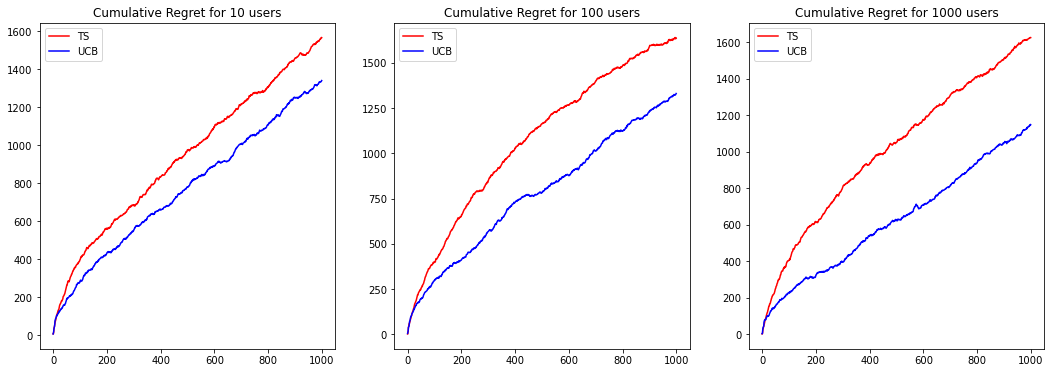

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,6))
ax[0].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_10, axis=0)), 'r')
ax[0].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_10, axis=0)), 'b')
ax[0].set_title("Cumulative Regret for 10 users")
ax[0].legend(["TS","UCB"])

ax[1].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_100, axis=0)), 'r')
ax[1].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_100, axis=0)), 'b')
ax[1].set_title("Cumulative Regret for 100 users")
ax[1].legend(["TS","UCB"])

ax[2].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_1000, axis=0)), 'r')
ax[2].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_1000, axis=0)), 'b')
ax[2].set_title("Cumulative Regret for 1000 users")
ax[2].legend(["TS","UCB"])

plt.show()